训练误差：训练数据上的误差
泛化误差：新数据上的误差

模型容量：拟合各种函数的能力
- 低容量的模型难以拟合训练数据
- 高容量的模型可以记住所有的训练数据

估计模型容量
- 难以在不同的算法之间做比较
- 给定一个模型种类，可以有2个主要的因素影响
  - 参数的个数
  - 参数值的选择范围

VC维： 针对一个分类模型，VC维等于一个最大的数据集的大小，不管如何给定符号，都存在一个模型对其进行完美分类
- 支持 N 维 输入的感知机的VC 维是 N + 1
- 一些多层感知机的VC维 是 O(Nlog2N)
- 使用的很少，深度学习模型的VC维很困难计算

数据复杂度
- 样本个数
- 每个样本的元素个数
- 时间，空间结构
- 多样性

目前 数据复杂度 和 模型复杂度 针对deep network无法评估，主要还是看训练和测试的误差

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

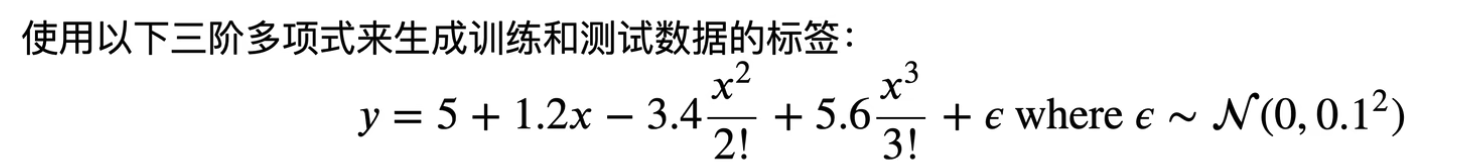

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [3]:
# 查看前4个数据

true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.0126],
         [ 0.0288]]),
 tensor([[ 1.0000e+00, -1.0126e+00,  5.1272e-01, -1.7306e-01,  4.3813e-02,
          -8.8733e-03,  1.4976e-03, -2.1664e-04,  2.7422e-05, -3.0854e-06,
           3.1244e-07, -2.8763e-08,  2.4272e-09, -1.8907e-10,  1.3675e-11,
          -9.2321e-13,  5.8429e-14, -3.4805e-15,  1.9580e-16, -1.0436e-17],
         [ 1.0000e+00,  2.8812e-02,  4.1508e-04,  3.9865e-06,  2.8715e-08,
           1.6547e-10,  7.9460e-13,  3.2706e-15,  1.1779e-17,  3.7710e-20,
           1.0865e-22,  2.8460e-25,  6.8333e-28,  1.5145e-30,  3.1169e-33,
           5.9870e-36,  1.0781e-38,  1.8273e-41,  2.9427e-44,  0.0000e+00]]),
 tensor([0.9530, 5.1067]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for x, y in data_iter:
        out = net(x)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.981098   1.2094594 -3.3966215  5.588836 ]]


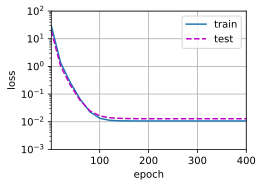

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])